In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Reshape

In [12]:
df = pd.read_csv('../data/bitcoin2023_t.csv')
print(df)

       candle_date_time_kst  opening_price  high_price  low_price   
0       2023-05-09T14:05:00       36994000    36995000   36973000  \
1       2023-05-09T14:00:00       37002000    37035000   36995000   
2       2023-05-09T13:55:00       37001000    37037000   37000000   
3       2023-05-09T13:50:00       37001000    37041000   37000000   
4       2023-05-09T13:45:00       37001000    37010000   37000000   
...                     ...            ...         ...        ...   
588858  2017-09-25T12:20:00        4215000     4242000    4203000   
588859  2017-09-25T12:15:00        4227000     4244000    4210000   
588860  2017-09-25T12:10:00        4215000     4236000    4212000   
588861  2017-09-25T12:05:00        4225000     4241000    4208000   
588862  2017-09-25T12:00:00        4201000     4224000    4195000   

        trade_price  candle_acc_trade_price  candle_acc_trade_volume  
0          36975000            5.779244e+08                15.624915  
1          36995000          

In [13]:
# 데이터 전처리
df['candle_date_time_kst'] = pd.to_datetime(df['candle_date_time_kst']) #datetime 변환
df.set_index('candle_date_time_kst', inplace=True)

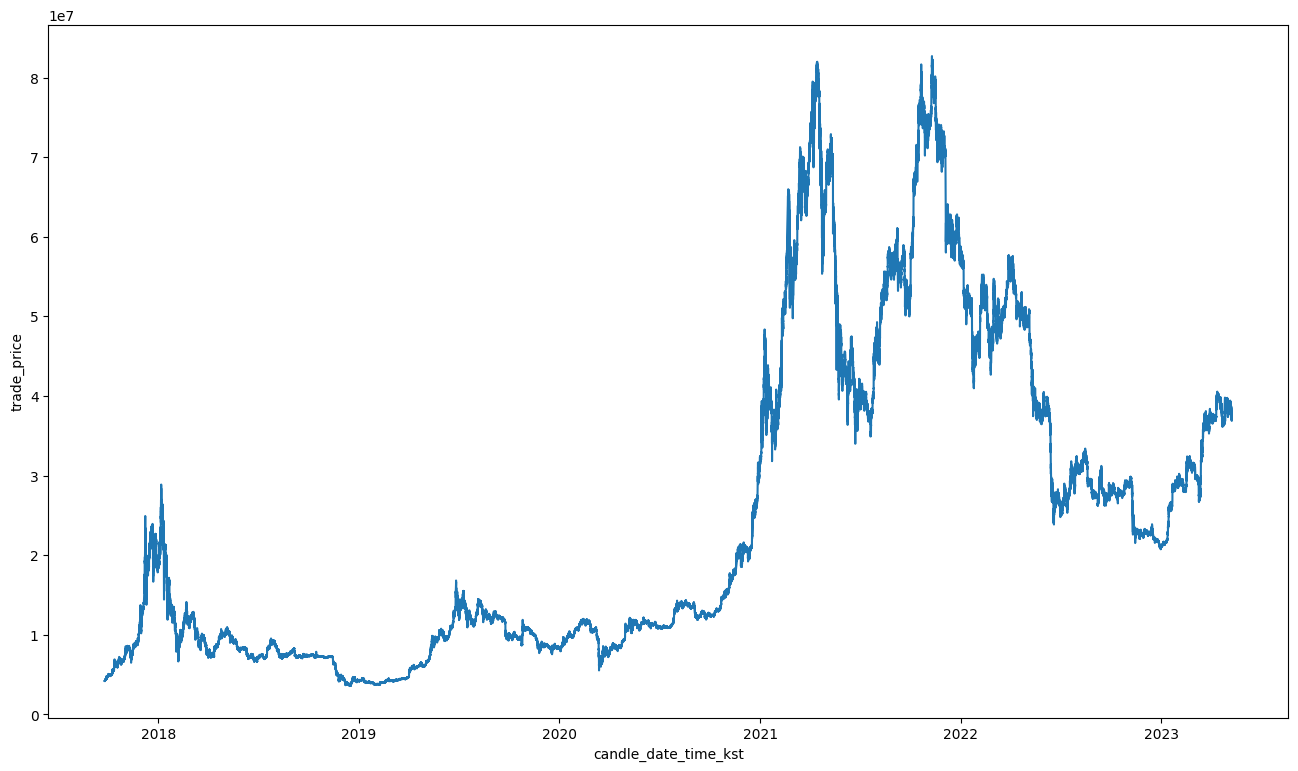

In [14]:
# 데이터 확인하기
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y="trade_price", data=df)
plt.xlabel("candle_date_time_kst")
plt.ylabel("trade_price")
plt.show()

In [16]:
# 결측치 처리
df = df.asfreq('60T') #60 간격마다 보관 시계열이용하기위한
df = df.interpolate(method='linear')
df = df.fillna(method='ffill')

In [17]:
# 이상치 제거
df = df[(np.abs(df['trade_price']) < 3*df['trade_price'].std()) & 
            (np.abs(df['candle_acc_trade_price']) < 3*df['candle_acc_trade_price'].std())]

In [18]:
# 데이터 정규화
scaler = MinMaxScaler()
scale_cols = ['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume']
scaled = scaler.fit_transform(df[['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume']])

# 데이터 셋 만들기
df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

       opening_price  high_price  low_price  trade_price   
0           0.011014    0.011190   0.011170     0.011455  \
1           0.011383    0.011383   0.011400     0.011651   
2           0.011338    0.011305   0.011367     0.011549   
3           0.011293    0.011228   0.011334     0.011448   
4           0.011247    0.011150   0.011301     0.011346   
...              ...         ...        ...          ...   
44919       0.587928    0.587745   0.594062     0.594352   
44920       0.591530    0.591312   0.597649     0.597531   
44921       0.589580    0.589485   0.595518     0.595400   
44922       0.588649    0.588501   0.594719     0.594796   
44923       0.587208    0.587570   0.593618     0.593482   

       candle_acc_trade_price  candle_acc_trade_volume  
0                    0.007293                 0.014524  
1                    0.006571                 0.013054  
2                    0.005678                 0.011281  
3                    0.004785                 0.009

In [19]:
# 데이터셋 분리 비율
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
'''
# 학습 데이터와 테스트 데이터로 분리
train_val_data, test_data = train_test_split(df, test_size=test_ratio, shuffle=False) #test_size 는 비율의미 shuffle=False 로 한이유는 시계열 특성을 고려?

# 학습 데이터와 검증 데이터로 분리
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False)
'''
# 학습 데이터와 테스트 데이터로 분리
test_data_size = int(len(df) * test_ratio)
train_val_data = df[:-test_data_size]
test_data = df[-test_data_size:]

# 학습 데이터와 검증 데이터로 분리
val_data_size = int(len(train_val_data) * val_ratio / (train_ratio + val_ratio))
train_data = train_val_data[:-val_data_size]
val_data = train_val_data[-val_data_size:]

# 데이터셋 생성 함수
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [20]:
# 학습 데이터셋 생성
n_timesteps = 24
X_train, y_train = create_dataset(train_data, train_data['trade_price'], n_timesteps)

# 검증 데이터셋 생성
X_val, y_val = create_dataset(val_data, val_data['trade_price'], n_timesteps)

# 테스트 데이터셋 생성
X_test, y_test = create_dataset(test_data, test_data['trade_price'], n_timesteps)


In [21]:
# CNN 모델과 LSTM 모델
n_features = 6

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.025))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.025))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Reshape((-1, 64)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [22]:
# 모델 학습하기
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# 모델 평가하기
score = model.evaluate(X_test, y_test)
print("Test loss:", score)

Epoch 1/100
982/982 [==============================] - 6s 6ms/step - loss: 3.3098e-04 - val_loss: 0.0014
Epoch 2/100
982/982 [==============================] - 5s 5ms/step - loss: 9.6962e-05 - val_loss: 7.0214e-04
Epoch 3/100
982/982 [==============================] - 5s 5ms/step - loss: 6.0572e-05 - val_loss: 3.0433e-04
Epoch 4/100
982/982 [==============================] - 5s 6ms/step - loss: 5.8282e-05 - val_loss: 8.1739e-04
Epoch 5/100
982/982 [==============================] - 5s 6ms/step - loss: 6.0750e-05 - val_loss: 7.2943e-04
Epoch 6/100
982/982 [==============================] - 5s 6ms/step - loss: 5.7761e-05 - val_loss: 5.8096e-04
Epoch 7/100
982/982 [==============================] - 5s 5ms/step - loss: 4.6093e-05 - val_loss: 0.0010
Epoch 8/100
982/982 [==============================] - 5s 5ms/step - loss: 5.4253e-05 - val_loss: 0.0020
Epoch 9/100
982/982 [==============================] - 5s 5ms/step - loss: 4.7155e-05 - val_loss: 6.6598e-04
Epoch 10/100
982/982 [=========

In [23]:
# 모델 예측하기
y_pred = model.predict(X_test)

140/140 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.2f}".format(mse))

# 사용 안해도된다.

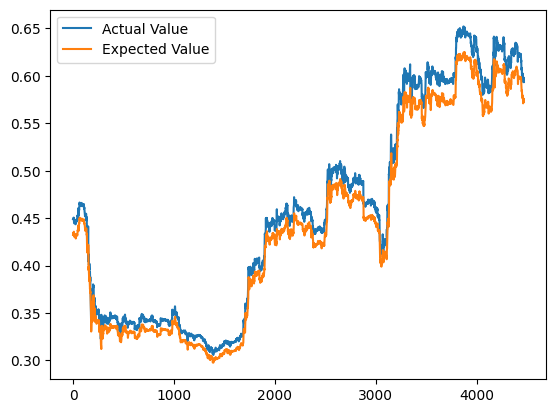

In [25]:
# 시각화 하기
plt.plot(y_test, label='Actual Value')
plt.plot(y_pred, label='Expected Value')
plt.legend()
plt.show()

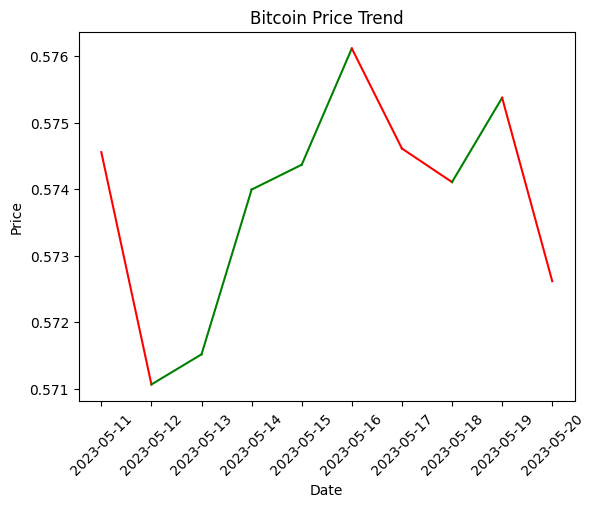

In [27]:
import matplotlib.pyplot as plt

# 데이터 준비
dates = [f"2023-05-{i}" for i in range(1, 31)]
dates_20 = dates[-20:]
y_pred_10 = y_pred[-10:]
y_pred_20 = y_pred_10[-20:]

# 상승/하락 여부에 따라 다른 색상의 선 그래프 그리기
fig, ax = plt.subplots()
for i in range(len(y_pred_20)-1):
    if y_pred_20[i+1] > y_pred_20[i]:
        ax.plot([dates_20[i], dates_20[i+1]], [y_pred_20[i], y_pred_20[i+1]], color='green')
    else:
        ax.plot([dates_20[i], dates_20[i+1]], [y_pred_20[i], y_pred_20[i+1]], color='red')

# 그래프 레이아웃 설정
ax.set_title('Bitcoin Price Trend')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# 그래프 출력
plt.xticks(rotation=45)
plt.show()
